In [37]:
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from finta import TA
import pandas as pd

class stock():
    def __init__(self,name):
        self.stock_df = pd.DataFrame(yf.Ticker(name).history(period="max"))
        self.name = name
        
    def Bollinger_bands(self,start,end, upper = True, lower = True):
        self.stock_df.columns = map(str.lower, self.stock_df.columns)
        bbands = TA.BBANDS(self.stock_df)
        sns.set()
        if upper :
            bbands[start:end].BB_UPPER.plot()
        if lower :
            bbands[start:end].BB_LOWER.plot()
        self.stock_df["open"][start:end].rolling(window=7, center =True).mean().plot(label="MA 7 jours",ls = ":")
        plt.show
        
        

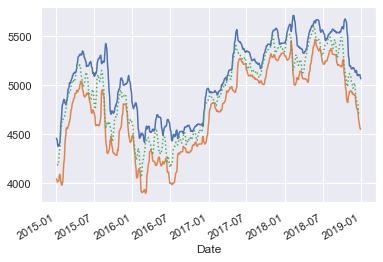

In [41]:
test = stock(name="^FCHI")
test.stock_df
test.Bollinger_bands("2015","2018")